# Attempt To Reproduce Results from Luz Rello, et al., (2020) **Predicting risk of dyslexia with an online gamified test**

* Program name: Master's in Computer Science - Artificial Intelligence (MAI)
* Student name: Kostadin Georgiev
* Student Id: 22229358

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load Data

Raw data is divided into 8 subsets: 6 subsets by age, and 2 subsets by gender.

In [2]:
# Exctract name of columns
features = pd.read_csv('data/Dyt-desktop.csv', delimiter=';').columns.values[:-1]

def load_data(path):
    data = pd.read_csv(path, delimiter=';')

    # Extract data points (features) as a NumPy array
    X = data.iloc[:, :-1].values

    # Extract labels as a NumPy array
    y = data['Dyslexia'].values
    y = np.where(y == 'Yes', 1, 0)

    return X, y

def filter_by_age(X, y, lower_limit, upper_limit):
    filtered_X = X[(X[:, 3] >= lower_limit) & (X[:, 3] <= upper_limit)]
    filtered_y = y[(X[:, 3] >= lower_limit) & (X[:, 3] <= upper_limit)]

    return filtered_X, filtered_y

def filter_by_gender(X, y, gender):
    filtered_X = X[(X[:, 0] == gender)]
    filtered_y = y[(X[:, 0] == gender)]

    return filtered_X, filtered_y

desktop_data, desktop_labels = load_data('data/Dyt-desktop.csv')
tablet_data, tablet_labels = load_data('data/Dyt-tablet.csv')

datasets = [
    { 'name': 'A1 (7-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 17), 'threshold': 0.240, 'n_folds': 10 },
    { 'name': 'A2 (9-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 9, 17), 'threshold': 0.260, 'n_folds': 10 },
    { 'name': 'A3 (7-11)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 11), 'threshold': 0.250, 'n_folds': 10 },
    { 'name': 'A4 (9-11)', 'dataset': filter_by_age(desktop_data, desktop_labels, 9, 11), 'threshold': 0.275, 'n_folds': 10 },
    { 'name': 'A5 (12-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 12, 17), 'threshold': 0.245, 'n_folds': 10 },
    { 'name': 'A6 (7-8)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 8), 'threshold': 0.150, 'n_folds': 10 },
    { 'name': 'Female', 'dataset': filter_by_gender(desktop_data, desktop_labels, 'Female'), 'threshold': 0.240, 'n_folds': 5 },
    { 'name': 'Male', 'dataset': filter_by_gender(desktop_data, desktop_labels, 'Male'), 'threshold': 0.240, 'n_folds': 5 }
]

secondary_datasets = [
    { 'name': 'N1 (12-17)', 'dataset': filter_by_age(tablet_data, tablet_labels, 12, 17), 'threshold': 0.155, 'n_folds': 10 },
    { 'name': 'N2 (9-11)', 'dataset': filter_by_age(tablet_data, tablet_labels, 9, 11), 'threshold': 0.230, 'n_folds': 10 },
    { 'name': 'N3 (7-8)', 'dataset': filter_by_age(tablet_data, tablet_labels, 7, 8), 'threshold': 0.255, 'n_folds': 10 },
]

### 2. Perform N-Fold Cross-Validation of a Random Forest Classifier

Mind that I am specifying `class_weight='balanced'` which is to comply with the following description (directly quoted from the paper): "For all cases we used weighted attributes to balance the dyslexia and non-dyslexia classes as a trivial classifier (that predicts that everyone does not have dyslexia) would have obtained an accuracy of 89.2%, since 89.2% of the participants do not have dyslexia."

I have also considered setting the classifier's threshold as mentioned by the authors (also direct quote from the paper): "As our goal is to have high recall (sensitivity) for the dyslexia class, we choose the Random Forest voting decision threshold such that the weight of the false negatives is similar to the weight of the false positives. This implies that we give between 8 to 9 times more importance to not send a child with dyslexia to the specialist than sending a child without dyslexia to the specialist. This implies that the threshold will be much less than 0.5, which is the default value. We discuss this issue in the next section. In Table 3 we give the confusion matrix of the best model for the overall data set."

I have made 2 assumtions as part of the pre-processing, because they respective detailes are missing in the paper:
* I have replaced NULL values with 0's.
* I have performed MinMax scaling for the data (except for columns with binary 0/1 values, or columns that represent "Accuracy", as they are already in the range 0-1).

In [3]:
def pre_process(data, labels, rescale=False):
    X, y = data, labels

    # Replace NaN values with 0s
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = np.nan_to_num(X[i][j])

    # Encode 'Male' to 0 and 'Female' to 1
    X[:, 0] = np.where(X[:, 0] == 'Male', 0, 1)

    # Encode 'Yes' to 1 and 'No' to 0
    X[:, 1] = np.where(X[:, 1] == 'Yes', 1, 0)
    X[:, 2] = np.where(X[:, 2] == 'Yes', 1, 0)

    # Perform Min-Max scaling for non-'Accuracy' columns
    if rescale == True:
        scaler = MinMaxScaler(feature_range=(0, 1))
        for i, feature in enumerate(features):
            if not feature.startswith('Accuracy'):
                column_values = X[:, i].astype(float).reshape(-1, 1)
                X[:, i] = scaler.fit_transform(column_values).flatten()
    
    return X, y

def cross_validate(data, labels, create_model, n_folds=10, threshold=0.5, seed=42):
    X, y = pre_process(data, labels, rescale=True)

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    accuracies = []
    recalls = []
    precisions = []
    rocs = []
    
    for train, test in kf.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        
        model = create_model(seed=seed)
        model.fit(X_train, y_train)

        predicted_probabilities = model.predict_proba(X_test)
        y_pred = (predicted_probabilities[:, 1] >= threshold).astype(int)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        precision = metrics.precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        roc_score = metrics.roc_auc_score(y_test, y_pred)
        
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        rocs.append(roc_score)
    
    accuracy = float("{:.1f}".format(np.mean(accuracies) * 100))
    recall = float("{:.1f}".format(np.mean(recalls) * 100))
    precision = float("{:.1f}".format(np.mean(precisions) * 100))
    roc = float("{:.3f}".format(np.mean(rocs)))

    return accuracy, recall, precision, roc

In [4]:
def random_forests_200(seed=42):
    return RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=seed)

### 3. Results from Base Paper

In [7]:
paper_results = pd.DataFrame(columns=['Dataset', 'Size', 'Accuracy', 'Recall', 'Precision', 'ROC', 'Threshold'])

paper_results.loc[0] = ['A1 (7-17)', 3644, 79.8, 80.6, 79.3, 0.873, 0.240]
paper_results.loc[1] = ['A2 (9-17)', 2734, 80.1, 79.9, 80.1, 0.878, 0.260]
paper_results.loc[2] = ['A3 (7-11)', 2540, 80.8, 80.9, 80.7, 0.868, 0.250]
paper_results.loc[3] = ['A4 (9-11)', 1629, 81.6, 82.0, 81.4, 0.878, 0.275]
paper_results.loc[4] = ['A5 (12-17)', 1106, 77.0, 77.0, 77.0, 0.851, 0.245]
paper_results.loc[5] = ['A6 (7-8)', 912, 69.2, 69.8, 69.0, 0.782, 0.150]
paper_results.loc[6] = ['Female', 1793, 78.3, 76.8, 79.2, 0.855, 0.240]
paper_results.loc[7] = ['Male', 1851, 76.8, 76.7, 76.8, 0.856, 0.240]

paper_results

,Dataset,Size,Accuracy,Recall,Precision,ROC,Threshold
0,A1 (7-17),3644,79.8,80.6,79.3,0.873,0.240
1,A2 (9-17),2734,80.1,79.9,80.1,0.878,0.260
2,A3 (7-11),2540,80.8,80.9,80.7,0.868,0.250
3,A4 (9-11),1629,81.6,82.0,81.4,0.878,0.275
4,A5 (12-17),1106,77.0,77.0,77.0,0.851,0.245
5,A6 (7-8),912,69.2,69.8,69.0,0.782,0.150
6,Female,1793,78.3,76.8,79.2,0.855,0.240
7,Male,1851,76.8,76.7,76.8,0.856,0.240


### 4. Optimise Thresholds

In [5]:
def optimise_threshold(create_model, seed=42):
    results = []

    for dataset in datasets:
        df = pd.DataFrame(columns=['Dataset', 'Size', 'Accuracy', 'Recall', 'Precision', 'ROC', 'Threshold'])

        for i, t in enumerate(np.arange(0.100, 0.305, 0.005)):
            name = dataset['name']
            data, labels = dataset['dataset']
            t = round(t, 3)
            n_folds = dataset['n_folds']
            accuracy, recall, precision, roc = cross_validate(data, labels, create_model, n_folds=n_folds, threshold=t, seed=seed)
            df.loc[i] = [name, len(data), accuracy, recall, precision, roc, "{:.3f}".format(t)]

        results.append(df)

    return results

In [6]:
results = optimise_threshold(random_forests_200, seed=42)

In [8]:
for i in range(len(paper_results)):
    paper_row = list(paper_results.loc[i][2:6])
    paper_x = paper_row[:2]
    paper_t = paper_results.loc[i][6]

    results_dataset = results[i].iloc[:, 2:6]
    results_x = results_dataset.iloc[:, :2]

    # Calculate cosine similarity between x and each row
    results_dataset['cos_sim_4'] = cosine_similarity(results_dataset.values, [paper_row]).flatten()
    results_dataset['cos_sim_2'] = cosine_similarity(results_x.values, [paper_x]).flatten()
    #print(results_dataset)

    # Find the row index with the highest cosine similarity
    id_max_4 = results_dataset['cos_sim_4'].idxmax()
    id_max_2 = results_dataset['cos_sim_2'].idxmax()

    # Get the row with the highest cosine similarity
    results_max_4 = list(results_dataset.iloc[id_max_4, :-2])
    results_max_2 = list(results_dataset.iloc[id_max_2, :-2])

    print('Dataset:\t\t\t\t\t', paper_results.loc[i][0])
    print('original results:\t\t\t\t', paper_row)
    print('most similar based on all metrics:\t\t', results_max_4, results[i].iloc[id_max_4, -1])
    print('most similar based on Accuracy and Recall:\t', results_max_2, results[i].iloc[id_max_2, -1])
    print()

Dataset:					 A1 (7-17)
original results:				 [79.8, 80.6, 79.3, 0.873]
most similar based on all metrics:		 [87.1, 58.3, 43.2, 0.744] 0.190
most similar based on Accuracy and Recall:	 [75.7, 76.2, 27.5, 0.76] 0.115

Dataset:					 A2 (9-17)
original results:				 [80.1, 79.9, 80.1, 0.878]
most similar based on all metrics:		 [88.0, 58.5, 50.1, 0.753] 0.235
most similar based on Accuracy and Recall:	 [78.0, 77.9, 32.6, 0.78] 0.130

Dataset:					 A3 (7-11)
original results:				 [80.8, 80.9, 80.7, 0.868]
most similar based on all metrics:		 [88.6, 49.0, 45.6, 0.711] 0.205
most similar based on Accuracy and Recall:	 [76.8, 78.4, 27.6, 0.775] 0.115

Dataset:					 A4 (9-11)
original results:				 [81.6, 82.0, 81.4, 0.878]
most similar based on all metrics:		 [87.4, 67.2, 48.3, 0.787] 0.220
most similar based on Accuracy and Recall:	 [81.1, 81.1, 36.9, 0.812] 0.150

Dataset:					 A5 (12-17)
original results:				 [77.0, 77.0, 77.0, 0.851]
most similar based on all metrics:		 [86.2, 56.3, 45.3, 0

In [9]:
datasets_optimal_threshold_1 = [
    { 'name': 'A1 (7-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 17), 'threshold': 0.190, 'n_folds': 10 },
    { 'name': 'A2 (9-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 9, 17), 'threshold': 0.235, 'n_folds': 10 },
    { 'name': 'A3 (7-11)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 11), 'threshold': 0.205, 'n_folds': 10 },
    { 'name': 'A4 (9-11)', 'dataset': filter_by_age(desktop_data, desktop_labels, 9, 11), 'threshold': 0.220, 'n_folds': 10 },
    { 'name': 'A5 (12-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 12, 17), 'threshold': 0.225, 'n_folds': 10 },
    { 'name': 'A6 (7-8)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 8), 'threshold': 0.100, 'n_folds': 10 },
    { 'name': 'Female', 'dataset': filter_by_gender(desktop_data, desktop_labels, 'Female'), 'threshold': 0.145, 'n_folds': 5 },
    { 'name': 'Male', 'dataset': filter_by_gender(desktop_data, desktop_labels, 'Male'), 'threshold': 0.220, 'n_folds': 5 }
]
datasets_optimal_threshold_2 = [
    { 'name': 'A1 (7-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 17), 'threshold': 0.115, 'n_folds': 10 },
    { 'name': 'A2 (9-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 9, 17), 'threshold': 0.130, 'n_folds': 10 },
    { 'name': 'A3 (7-11)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 11), 'threshold': 0.115, 'n_folds': 10 },
    { 'name': 'A4 (9-11)', 'dataset': filter_by_age(desktop_data, desktop_labels, 9, 11), 'threshold': 0.150, 'n_folds': 10 },
    { 'name': 'A5 (12-17)', 'dataset': filter_by_age(desktop_data, desktop_labels, 12, 17), 'threshold': 0.130, 'n_folds': 10 },
    { 'name': 'A6 (7-8)', 'dataset': filter_by_age(desktop_data, desktop_labels, 7, 8), 'threshold': 0.100, 'n_folds': 10 },
    { 'name': 'Female', 'dataset': filter_by_gender(desktop_data, desktop_labels, 'Female'), 'threshold': 0.110, 'n_folds': 5 },
    { 'name': 'Male', 'dataset': filter_by_gender(desktop_data, desktop_labels, 'Male'), 'threshold': 0.120, 'n_folds': 5 }
]

In [10]:
def run_experiment(dataset_list, create_model, seed=42):
    results = pd.DataFrame(columns=['Dataset', 'Size', 'Accuracy', 'Recall', 'Precision', 'ROC', 'Threshold'])

    for i, dataset in enumerate(dataset_list):
        name = dataset['name']
        data, labels = dataset['dataset']
        t = dataset['threshold']
        n_folds = dataset['n_folds']
        accuracy, recall, precision, roc = cross_validate(data, labels, create_model, n_folds=n_folds, threshold=t, seed=seed)
        results.loc[i] = [name, len(data), accuracy, recall, precision, roc, "{:.3f}".format(t)]

    return results

### 5. Results using the same thresholds as reported in the base paper.

In [11]:
result_exp_01 = run_experiment(datasets, random_forests_200, seed=42)

In [12]:
result_exp_01

,Dataset,Size,Accuracy,Recall,Precision,ROC,Threshold
0,A1 (7-17),3644,89.1,45.4,49.7,0.699,0.240
1,A2 (9-17),2733,88.6,52.4,53.0,0.730,0.260
2,A3 (7-11),2539,90.1,35.4,53.4,0.659,0.250
3,A4 (9-11),1628,88.9,49.1,54.3,0.718,0.275
4,A5 (12-17),1105,87.1,49.9,47.1,0.711,0.245
5,A6 (7-8),911,88.0,33.5,26.6,0.628,0.150
6,Female,1793,88.8,27.2,41.8,0.614,0.240
7,Male,1851,88.7,45.9,51.1,0.701,0.240


### 6. Results using optimised thresholds based on Accuracy, Recall, Precision and ROC.

In [13]:
result_exp_02 = run_experiment(datasets_optimal_threshold_1, random_forests_200, seed=42)

In [14]:
result_exp_02

,Dataset,Size,Accuracy,Recall,Precision,ROC,Threshold
0,A1 (7-17),3644,88.5,64.7,47.6,0.780,0.190
1,A2 (9-17),2733,88.4,63.6,51.7,0.777,0.235
2,A3 (7-11),2539,88.4,50.4,44.1,0.716,0.205
3,A4 (9-11),1628,86.9,62.4,46.5,0.764,0.220
4,A5 (12-17),1105,87.3,62.0,48.7,0.765,0.225
5,A6 (7-8),911,81.3,53.7,21.6,0.685,0.100
6,Female,1793,83.2,67.7,33.2,0.763,0.145
7,Male,1851,88.7,56.8,51.1,0.748,0.220


### 7. Results using optimised thresholds based only on Accuracy and Recall.

In [15]:
result_exp_03 = run_experiment(datasets_optimal_threshold_2, random_forests_200, seed=42)

In [16]:
result_exp_03

,Dataset,Size,Accuracy,Recall,Precision,ROC,Threshold
0,A1 (7-17),3644,76.8,80.0,29.1,0.782,0.115
1,A2 (9-17),2733,78.9,82.1,34.2,0.803,0.130
2,A3 (7-11),2539,76.6,80.1,27.9,0.782,0.115
3,A4 (9-11),1628,81.0,79.9,36.7,0.806,0.150
4,A5 (12-17),1105,77.6,79.8,32.8,0.786,0.130
5,A6 (7-8),911,81.3,53.7,21.6,0.685,0.100
6,Female,1793,76.9,79.2,27.2,0.779,0.110
7,Male,1851,73.6,76.6,27.3,0.749,0.120


### 8. Comparison of results using different thresholds with results from base paper.

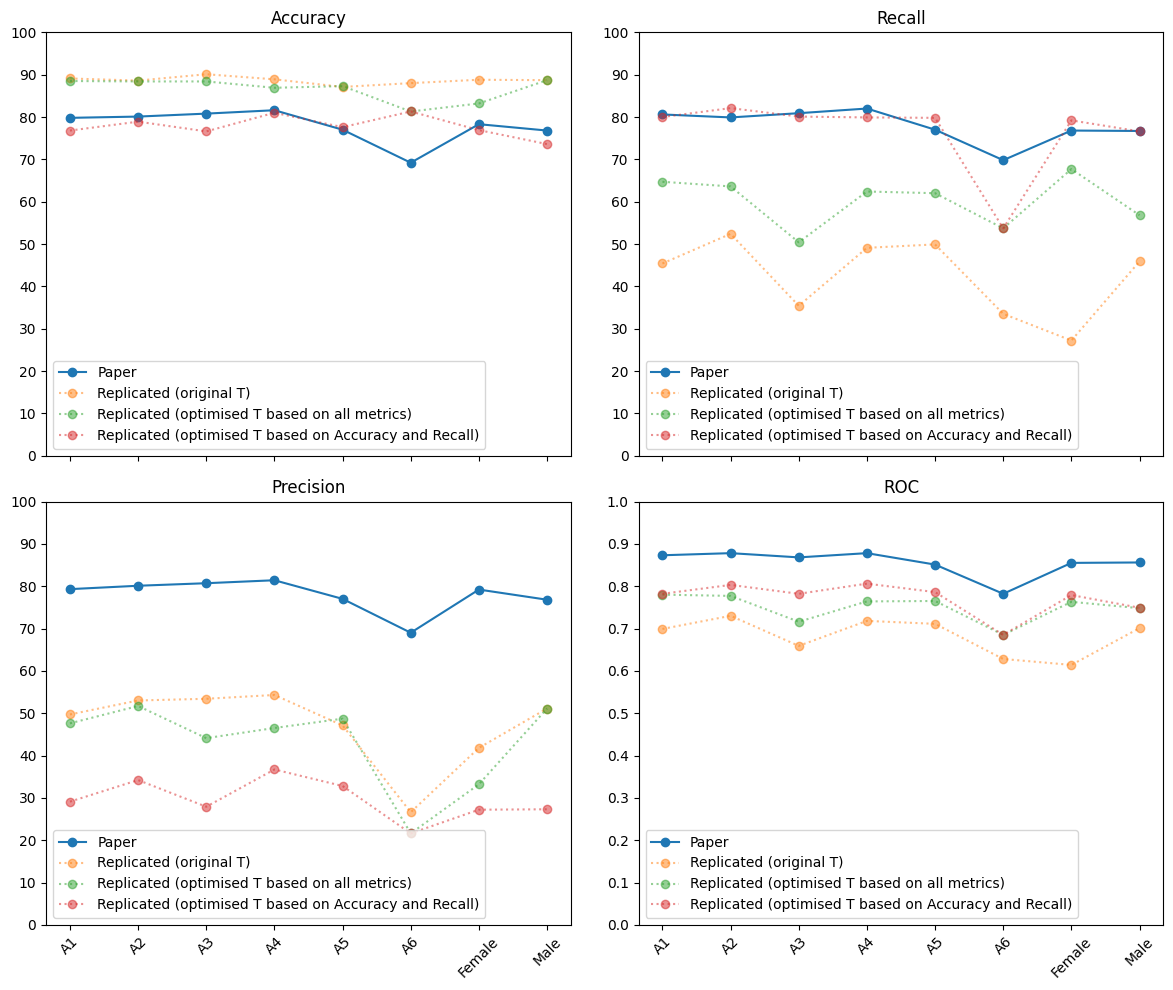

In [17]:
table_A = paper_results.loc[:, 'Accuracy':'ROC'].values
table_B = result_exp_01.loc[:, 'Accuracy':'ROC'].values
table_C = result_exp_02.loc[:, 'Accuracy':'ROC'].values
table_D = result_exp_03.loc[:, 'Accuracy':'ROC'].values

# Define the performance metrics and datasets
result_metrics = ['Accuracy', 'Recall', 'Precision', 'ROC']
datasets = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'Female', 'Male']
x = np.arange(len(datasets))  # x-axis locations for the datasets

# Create the faceted plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True)

for i, ax in enumerate(axes.flat):
    metric = result_metrics[i]
    y = []
    
    if i < 3:
        y = np.arange(0, 101, 10)
    else:
        y = np.arange(0, 1.1, 0.1)

    ax.plot(x, table_A[:, i], linestyle='-', marker='o', label='Paper', alpha=1)
    ax.plot(x, table_B[:, i], linestyle=':', marker='o', label='Replicated (original T)', alpha=0.5)
    ax.plot(x, table_C[:, i], linestyle=':', marker='o', label='Replicated (optimised T based on all metrics)', alpha=0.5)
    ax.plot(x, table_D[:, i], linestyle=':', marker='o', label='Replicated (optimised T based on Accuracy and Recall)', alpha=0.5)

    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45)
    ax.set_yticks(y)
    ax.set_title(metric)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()